# Split test analysis: Matchmaker dashboard
This notebook details an analysis of the matchmaker dashboard split test. This test split users randomly between the current carer feature in a list format (the control group) and a newly designed matchmaker dashboard (intervention group).
## Hypothesis
The purpose of the test is to determine whether the booking rate (the % of users who booked) was higher in the intervention group than the control group. Our (one-tail) hypothesis test is set up as follows.
- The null hypothesis is that the intervention group is not higher:
    - Intervention booking rate <= Control booking rate
- The alternate hypothesis is that the intervention group is higher:
    - Intervention booking rate > Control booking rate
## Step 1: Cleaning and preparation

In [18]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from random import sample
from math import ceil
from tabulate import tabulate

In [19]:
# loading the exercise file into a pandas dataframe (from the default directory) and previewing the data
df = pd.read_csv('Senior Data Analyst Second Round Practical Exercise Data.csv')
df.head(n=10)

,unique_id,test_group,booked,type_of_care,account_type,relationship_length_sought,schedule
0,2WPVxZ0,Intervention,False,Disability Support,Self Managed,Ongoing,Flexible
1,2Wpgia8,Intervention,False,Disability Support,Self Managed,Ongoing,Specific
2,2WK9Bq4,Intervention,False,Other,Self Managed,Ongoing,Flexible
3,2Vv-cok,Intervention,False,Other,Self Managed,Once_Off,Flexible
4,2vRLGyQ,Control,True,Aged Care,Self Managed,Ongoing,Flexible
5,2VpFOP4,Control,True,Disability Support,Self Managed,Ongoing,Flexible
6,2VpFOP4,Control,True,Disability Support,Self Managed,Ongoing,Specific
7,2uq7kkU,Intervention,False,Aged Care,Self Managed,Ongoing,Specific
8,2umaI8U,Intervention,False,Disability Support,Self Managed,Ongoing,Specific
9,2UkVGy0,Intervention,True,Aged Care,Self Managed,Ongoing,Specific


In [20]:
df.describe() 

,unique_id,test_group,booked,type_of_care,account_type,relationship_length_sought,schedule
count,299,299,299,299,299,299,299
unique,259,2,2,5,2,2,2
top,1IemLu8,Intervention,False,Disability Support,Self Managed,Ongoing,Specific
freq,2,150,200,186,282,241,168


There are no missing values in the dataset, however the 'unique_id' field appears not to be unique: 259 unique values out of 299 records (40 users are duplicated). This is an issue becasue we care about the proportion of unique users who book and if a user is represented more than once we could be 'double counting' in our results.

Displaying the duplicates:

In [21]:
has_duplicate_id = df.duplicated('unique_id', keep = False) # returns true/false against the df index for duplicates of unique_id
df_duplicate_ids = df[has_duplicate_id] # new dataframe sliced for duplicates of unique_id
df_duplicate_ids.sort_values(by=['unique_id']) # sorted df by unique_id

print(tabulate(df_duplicate_ids.head(10), headers = 'keys', tablefmt = 'psql')) 

+----+-------------+--------------+----------+--------------------+----------------+------------------------------+------------+
|    | unique_id   | test_group   | booked   | type_of_care       | account_type   | relationship_length_sought   | schedule   |
|----+-------------+--------------+----------+--------------------+----------------+------------------------------+------------|
|  5 | 2VpFOP4     | Control      | True     | Disability Support | Self Managed   | Ongoing                      | Flexible   |
|  6 | 2VpFOP4     | Control      | True     | Disability Support | Self Managed   | Ongoing                      | Specific   |
| 15 | 2tCmEGE     | Control      | False    | Mental Health      | Self Managed   | Once_Off                     | Specific   |
| 16 | 2tCmEGE     | Control      | False    | Mental Health      | Self Managed   | Ongoing                      | Flexible   |
| 25 | 2qN6G9U     | Intervention | True     | Disability Support | Self Managed   | Ongoing     

Displaying where the mulitple rows against 'unique_id' are diferent:

In [22]:
duplicate_id_count = df_duplicate_ids.groupby(['unique_id']).nunique()

print(tabulate(duplicate_id_count, headers = 'keys', tablefmt = 'psql'))

+-------------+--------------+----------+----------------+----------------+------------------------------+------------+
| unique_id   |   test_group |   booked |   type_of_care |   account_type |   relationship_length_sought |   schedule |
|-------------+--------------+----------+----------------+----------------+------------------------------+------------|
| 0MKWb_4     |            1 |        1 |              1 |              1 |                            2 |          2 |
| 0QCBUrY     |            1 |        1 |              1 |              1 |                            2 |          2 |
| 0SRr4XY     |            1 |        1 |              1 |              1 |                            1 |          2 |
| 0YDjLjI     |            1 |        1 |              1 |              1 |                            2 |          2 |
| 0aCzOGo     |            1 |        1 |              1 |              1 |                            1 |          2 |
| 0k7mLCU     |            1 |        1 

Examining the duplicates* above confirms the following:
1. There are 80 duplicates consisting of 40 unique_ids, each repeated twice. 22 of these ids are present in the control group and 18 in the intervention group.
2. With exeption of one unique_id (below), all column values (attributes) except 'relationship_lenght_sought' and 'schedule' are the same across these duplicates i.e. it is only those two attributes that differ. The fact that the booked status is not different in these records is especially important because it makes these records usable against the metric of concern.
    * It also means that it is unlikely that these duplicates represent seperate bookings but are rather repeated records about the same booking - perhaps where the user has selected different scheduling or relationship options during the course of the booking. 
3. One unique_id (1RupGAI) is present in both the control and intervention group. 

*It may be more correct to refer to these records as multiple user records rather than duplicates, but the term is used for simplicity's sake.

In [23]:
test_group_id_dup_indexes = duplicate_id_count[duplicate_id_count['test_group'] > 1] # identifying ids present in both control and test group
print(test_group_id_dup_indexes)

df_clean = df.drop(df[ df['unique_id'] == '1RupGAI'].index, inplace = True) # dropping offending unique id (hardcoded for now)

# unique_id duplicates removed: since booking status is the same for all duplicated users, this ensures that user bookings are only counted once
df_clean = df.drop_duplicates(subset =['unique_id'], keep = 'first') 

           test_group  booked  type_of_care  account_type  \
unique_id                                                   
1RupGAI             2       1             1             1   

           relationship_length_sought  schedule  
unique_id                                        
1RupGAI                             2         2  


Cleaning steps undertaken:
1. The id present in both test group and intervention group was dropped
2. Duplicate records per user removed such that there is only one booking record per user

In [24]:
df_clean.describe()

,unique_id,test_group,booked,type_of_care,account_type,relationship_length_sought,schedule
count,258,258,258,258,258,258,258
unique,258,2,2,5,2,2,2
top,1sApNjo,Intervention,False,Disability Support,Self Managed,Ongoing,Specific
freq,1,132,173,158,243,203,143


## Step 2: Evaluation

The aim of this test to determine whether the relative uplift of booking rate seen in the intervention group is statistically significant, and if so accept the alternate hypothesis. In other words we are looking to confirm, within a level of confidence, that the improvement seen is because of the changes we made rather than as a result of random chance. Our confidence level will be set at 95%, meaning that we wish to be 95% confident the results are not a result of random chance. The evaluation of the split test will be conducted via two methods: method 1 being a two-proportions-z-test and the second method being a permutations test.
### Summarising results
First we consider a summary of the results of the split test

In [25]:
summary_table = df_clean.groupby('test_group').agg({'booked': ['count', 'sum', 'mean', 'sem','std']}) # create aggregated table. The mean will be equal to the booking_rate
summary_table.columns = ['number_users','number_booked', 'booking_rate', 'std_error', 'std_dev'] #renamed columns
summary_table

,number_users,number_booked,booking_rate,std_error,std_dev
test_group,,,,,
Control,126,41,0.325397,0.041906,0.470393
Intervention,132,44,0.333333,0.041187,0.473200


In [26]:
# calculating the relative uplift (difference between test_groups)
intervention_booking_rate = summary_table.loc['Intervention','booking_rate']
control_booking_rate = summary_table.loc['Control','booking_rate']
percentage_points_difference = intervention_booking_rate - control_booking_rate
relative_uplift = percentage_points_difference / control_booking_rate

# printing a statement which summarises the difference
print('The intervention group booking rate of',
    round(100 * intervention_booking_rate,2), 'percent is',
    100*round(relative_uplift,4) ,'percent higher (or',round(100*(percentage_points_difference),2),
    'percentage points higher) than control group booking rate of', round(100*control_booking_rate,2))

The intervention group booking rate of 33.33 percent is 2.44 percent higher (or 0.79 percentage points higher) than control group booking rate of 32.54


There is only a very small difference in the booking rates between the two groups and the varience within these groups is close to equal. The high error score flags a high chance of us making a Type II error - where we mistakenly fail to reject the null hypotheses i.e. say that the uplift is not better when it is. 
## Evaluation method 1: two-proportions-z-test

The two-proportions-z-test is the appropriate statistical test because our data - being binary - summarises to proprotions (percentages). A two-proportion-z-test allows you to compare two proportions to see if they are the same. The student-t-test could also be used but will yield very similar results since the test using a normal distribution for over 100 samples. All of the assumptions for this test are met (independant samples, radomization condition, success/fauilure condition).

A one-tail rather than a two-tail test is justified in our case because we only care about testing one direction (whether the intervention group's rate is higher).

Running the test: 

In [27]:
# setting the variables required for the test
significance = 0.05
intervention_n = summary_table.loc['Intervention','number_users']
control_n = summary_table.loc['Control','number_users']
intervention_success = summary_table.loc['Intervention','number_booked']
control_success = summary_table.loc['Control','number_booked']
successes = np.array([control_success, intervention_success])
nobs = np.array([control_n, intervention_n])

# running the test
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# running the confidence intervals
(lower_control, lower_intervention), (upper_control, upper_intervention) = proportion_confint(successes, nobs=nobs, alpha=0.05)

# printing the results
print(f'z statistic: {z_stat:.2f}')
print(f'two_tailed_p-value: {pval:.3f}')
print(f'one_tailed_p-value: {pval/2.0:.3f}')
print(f'confidence interval 95% for the control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'confidence interval 95% for the intervention group: [{lower_intervention:.3f}, {upper_intervention:.3f}]')

z statistic: -0.14
two_tailed_p-value: 0.892
one_tailed_p-value: 0.446
confidence interval 95% for the control group: [0.244, 0.407]
confidence interval 95% for the intervention group: [0.253, 0.414]


The results confirm that the difference is **not statistically significant**. Specifically, the one_tailed_p_value  means that there is a **44.6 percent chance that this same or greater level of uplift could be seen by random chance**. However, the large confidence intervals (the values that we are 95% confident the true value lies between) make it highly likely that failing to reject the null would be the result of a Type II error. We investigate this later in the power analysis section.


Visualising the result

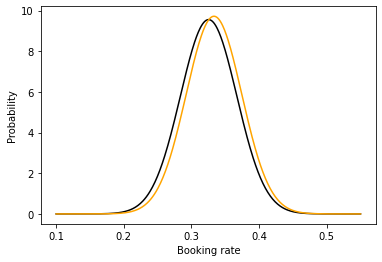

In [28]:
#defining the variables required
std_control_booking_rate = np.sqrt(control_booking_rate * (1 - control_booking_rate) / control_n)
std_intervention_booking_rate = np.sqrt(intervention_booking_rate * (1 - intervention_booking_rate) / intervention_n)
click_rate = np.linspace(0.1, 0.55, 500)
prob_control = stats.norm(control_booking_rate,std_control_booking_rate).pdf(click_rate)
prob_intervention = stats.norm(intervention_booking_rate,std_intervention_booking_rate).pdf(click_rate)

# plotting the distributions
plt.plot(click_rate, prob_control, label="Control", color = 'black')
plt.plot(click_rate, prob_intervention, label="Intervention", color = 'orange')
plt.xlabel("Booking rate"); plt.ylabel("Probability");

This visualisation shows that the probability distribuion for the intervention group in orange closely mirrors that of the control group. This means that the possible booking rate values we would expect to see from our intervention group would also be seen in our control group - hence the lack of statistical significance.

## Evaluation method 2: permutations test
A second method of evaluating the split test is the permutations method. The permutaitions test has the advantages not requring any assumptions and producing a test that is both specific about the direction of our hypothesis and precise. 

This test is a simulation where users from our split test are allocated to a control group and intervention group randomly. It works by completing many runs of the following process:
1. Randomly allocating the users (and their booking status) to a test group and an intervention group of the same size. 
2. Calulating the difference between the booking rate's of these two groups.

When distributing the differences between these these groups we can test the simulated probability of an the uplift we see occuring by random chance.

Running the test:

In [30]:
all_values = df_clean['booked'].astype(int).to_list() # grabbing all the booking status into a binary array
permuntations = 10000 # number of permutations
permuntations_results = [0]*permuntations # list for permuntation results

# this loop allocates the values into two groups the sizes of the control and intervention group and adds calculated difference into the permulation_results list
for i in range(permuntations):
    shuffled_values = sample(all_values, k=len(all_values)) # shuffle the booked values
    sim_intervention_group = shuffled_values[:intervention_n] # takes last intervention n values for group a
    sim_control_group = shuffled_values[control_n:] # takes the first control n values for group b
    sim_intv_booking_rate = 100* sum(sim_intervention_group) / intervention_n # calculates booking rate for the simulated intervention group
    sim_con_booking_rate = 100* sum(sim_control_group) / control_n # calculates the booking rate for the simulated control group
    permuntations_results[i] = sim_intv_booking_rate - sim_con_booking_rate # calulates the difference and adds to the list

print(permuntations_results[:10])

[1.5151515151515156, 0.0, -4.653679653679653, 3.860028860028862, 1.5512265512265557, -0.7936507936507908, 7.756132756132761, 0.0, 1.5512265512265557, 1.5512265512265557]


Now to evaluate the groud truth (difference between the Intervention group and control group's rates) against our simulated results.

In [31]:
# creating a series of the permutation results
permuntations_results_series = pd.Series(permuntations_results)

# bringing the pertage point difference onto the same scale as the series
ground_truth = 100*percentage_points_difference 

# calulating the number of results that are equal to or higher than the ground truth
pos_extreme_count = sum(permuntations_results_series >= ground_truth)
print('One=way: Extreme count: ', pos_extreme_count,
      '\nOne-way: p-value:', pos_extreme_count / permuntations) # printing results

One=way: Extreme count:  3241 
One-way: p-value: 0.3241


Our permutations test shows 32% probability that the same or greater difference in booking rates would be achieved by random chance. 

Visualising this result: 

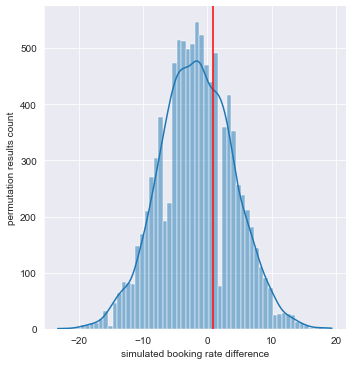

In [32]:
sns.set_style('darkgrid') # display settings

ax = sns.displot(data=permuntations_results_series, # creating plot
                 kde= True, 
                 legend = True)  

plt.axvline(x = ground_truth, color='red', label = 'ground_truth') #plotting observed difference as a red line

ax.set( xlabel = "simulated booking rate difference", ylabel = "permutation results count")


This visualisation shows the distribution of simulated booking rate differences and the difference observed in our split test as the red line. As we can see the red line is almost central to the distribution mean it is a very probable outcome of random chance. 

## Power analysis
We mentioned that the chance of us making a type II error and incorrecly concluding that there is no difference (saying our dashboard is not better when it is) could be high. The likelyhood of making this type II error can be calculated with called statistical power analysis. We can we can also use this analysis to determine the number of samples we require based on the level of difference we want to detect: the more samples we have, the more confident we are that the observed booking rate is the "true" booking rate.

First let's calculate the number of samples required to observe the difference we are currently seeing with a low probability of a type II error.

In [ ]:
effect_size = sms.proportion_effectsize(control_booking_rate, intervention_booking_rate)    # Calculating effect size based on our observed rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(' A sample size of', required_n, 'is required to observe the relative uplift of', 
     100*round(relative_uplift,4), 'with only a 20% probability of a type II error')

# high chance of us rejecting the null incorrectly - type 2 error

 A sample size of 55047 is required to observe the relative uplift of 2.44 with only a 20% probability of a type II error


The number of sample sizes required is not realistic for out test or platform but then again neither is the realtive uplift enough we've observed enough to warrant a change to our current procedure. 

What we need to do is decide on the effect size we want to observe and tie it to our actions **prior to the test**.

For example - "If we see an statistically significant uplift of 10% we will implement the new dashboard, otherwise our default action will be to continue with our current feature." 

The below table is designed to help us set up our next test accordingly. 

In [ ]:
# setting viables for the power analysis
power = 0.8
alpha = 0.05
ratio = 1

control_base =  np.average(all_values) # using the booking_rate of the combined groups as a base
perent_multiplier = 1.00 # adjust control_base to the intervention booking rate sought
required_samples = [] # list for the number of required samples 
percent_difference_sought = [] # list for the percentage difference sought

while perent_multiplier <= 1.50:
    perent_multiplier = perent_multiplier + 0.05 # increments of 5%
    intervention_sought = control_base * perent_multiplier # adjust base rate to be the appropriate % higher
    effect_size = sms.proportion_effectsize(control_base, intervention_sought) # calculate effect size
    required_n = sms.NormalIndPower().solve_power(effect_size, # calcuate power
                                                  power = power, 
                                                  alpha = alpha, 
                                                  ratio = ratio)
    required_n = ceil(required_n) # round samples to next number
    percent_difference_sought.append((perent_multiplier-1)*100) # append sought to list
    required_samples.append(required_n) # append samples to slist

In [ ]:
results_dict = {'percent_difference_sought' : percent_difference_sought , #create dictionary with result data
                'required_sample_size': required_samples}
results_df = pd.DataFrame(results_dict) # convert to dataframe

print(tabulate(results_df, #print table
               headers = 'keys', 
               tablefmt = 'psql')) 

+----+-----------------------------+------------------------+
|    |   percent_difference_sought |   required_sample_size |
|----+-----------------------------+------------------------|
|  0 |                           5 |                  12937 |
|  1 |                          10 |                   3271 |
|  2 |                          15 |                   1469 |
|  3 |                          20 |                    834 |
|  4 |                          25 |                    539 |
|  5 |                          30 |                    377 |
|  6 |                          35 |                    279 |
|  7 |                          40 |                    215 |
|  8 |                          45 |                    171 |
|  9 |                          50 |                    139 |
+----+-----------------------------+------------------------+


This table will assist us in setting up the next split test to avoid the risk of a type II error.
## Conclusion
In conclusion, the evaluation of this split test indicates there is not a statistically significant difference between the groups. The high confidence interval does spread some doubt, however, in our ability to accept the null hypthothes without error when we use a classic statistical test (method 1).

 Therefore, if we are content that this test accurately reflects our user base (in terms of the time the test was run and the number of users), we should interpret the result as a call to keep things as they are. If however, we are unsure, the power analysis conducted affords us the chance to run this test again and ensure that we collect enough samples to confidently avoid a type II error.